In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as knn
from category_encoders import TargetEncoder


from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# sns.set(font_scale=1.2)
# sns.set_style("whitegrid", {'grid.linestyle':'--'})

# Motivation
### Housing price trends are not only relevant to buyers and sellers, it is also an important indicator of the economic situation. Given the current economic status, we decided to work with a housing dataset. 

### Our main goal is to use features like view, condition, year built and renovated, city, and state to predict the housing price. As a result, our target variable is `price`.

## Step 1

### Understand dataset and its features at hand by:
### 1) Understanding the sparcity of the dataset
### 2) Identifying continuous and categorical variables
### 3) Understand distribution of target variable and remove outliers
### 4) Identify potential problems like information leakage
### 5) Visualize and understand distribution of each feature
### 6) Understand relationship/correlation between features

### Understand the sparcity of the dataset
#### Load in dataset

In [2]:
data = "data.csv"
df = pd.read_csv(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [3]:
df.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

#### As we can see from above, the dataset has no missing values. 

In [4]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


### Determine which features are continuous vs. categorical.

In [5]:
categorical_var = ['bedrooms','bathrooms','floors','waterfront',
                   'view','condition','street','city','statezip','country', 'yr_renovated']
continuous_var = ['sqft_living','sqft_lot','sqft_above','sqft_basement','yr_built'
                  ]
for col in categorical_var:
    df[col] = df[col].astype('object')
print(f'categorical variables: {categorical_var}')
print(f'continuous variables: {continuous_var}')

categorical variables: ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'street', 'city', 'statezip', 'country', 'yr_renovated']
continuous variables: ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built']


### Drop rows without a valid sales price. Visualize target variable and remove outliers

In [6]:
df = df[df.price != 0]

In [7]:
df['price'].describe()


count    4.551000e+03
mean     5.579059e+05
std      5.639299e+05
min      7.800000e+03
25%      3.262643e+05
50%      4.650000e+05
75%      6.575000e+05
max      2.659000e+07
Name: price, dtype: float64

<AxesSubplot:>

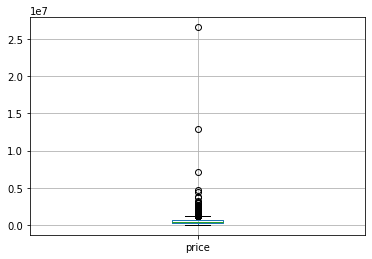

In [8]:
df.boxplot('price')

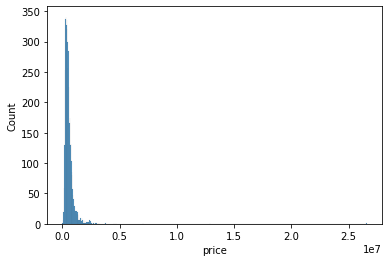

In [9]:
sns.histplot(df.price);

In [10]:
def remove_outliers(data, x):
    ##lets set the limits
    q25 = np.percentile(data[x], 25)
    q75 = np.percentile(data[x], 75)
    iqr = q75 - q25
    # removing values that fall outside of 1.5x the interquantile range
    cut_off = iqr * 1.5
    lower, upper = 1, (q75 + cut_off)
    data = data[(data[x] < upper) & (data[x] > lower)]
    print(f"Outliers of {x} are removed\n")
    return data

In [11]:
df = remove_outliers(df, 'price')

Outliers of price are removed



<AxesSubplot:>

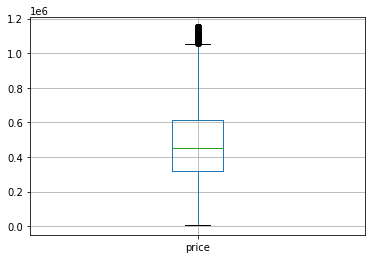

In [12]:
df.boxplot('price')

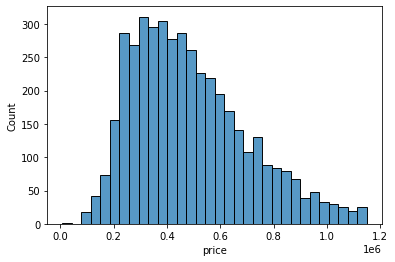

In [13]:
sns.histplot(df.price);

### Identify features that can potentially lead to information leakage

In [14]:
df.nunique()

date               70
price            1568
bedrooms           10
bathrooms          22
sqft_living       505
sqft_lot         2944
floors              6
waterfront          2
view                5
condition           5
sqft_above        463
sqft_basement     191
yr_built          115
yr_renovated       58
street           4240
city               44
statezip           77
country             1
dtype: int64

In [15]:
# Dropping street as it is the exact street address of each house - which is unique to each listing thus can
# lead to information leakage

# Dropping country as all listings are in the US.
df_features = df.drop(columns=['price', 'street', 'country'])
categorical_var.remove('street')
categorical_var.remove('country')

# Manipulating the statezip column by separating it into 2 columns
df_features[['state','zip']] = df_features.statezip.str.split(expand=True) 
df_features = df_features.drop(columns=['statezip'])
categorical_var.remove('statezip')
categorical_var.append('state')
categorical_var.append('zip')

df_features.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,state,zip
0,2014-05-02 00:00:00,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline,WA,98133
2,2014-05-02 00:00:00,3.0,2.0,1930,11947,1.0,0,0,4,1930,0,1966,0,Kent,WA,98042
3,2014-05-02 00:00:00,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,Bellevue,WA,98008
4,2014-05-02 00:00:00,4.0,2.5,1940,10500,1.0,0,0,4,1140,800,1976,1992,Redmond,WA,98052
5,2014-05-02 00:00:00,2.0,1.0,880,6380,1.0,0,0,3,880,0,1938,1994,Seattle,WA,98115


### Visualize the univariate distribution of each continuous features and the distribution of the target 

In [16]:
to_plot = continuous_var
to_plot.append('price')

In [17]:
to_plot2 = categorical_var


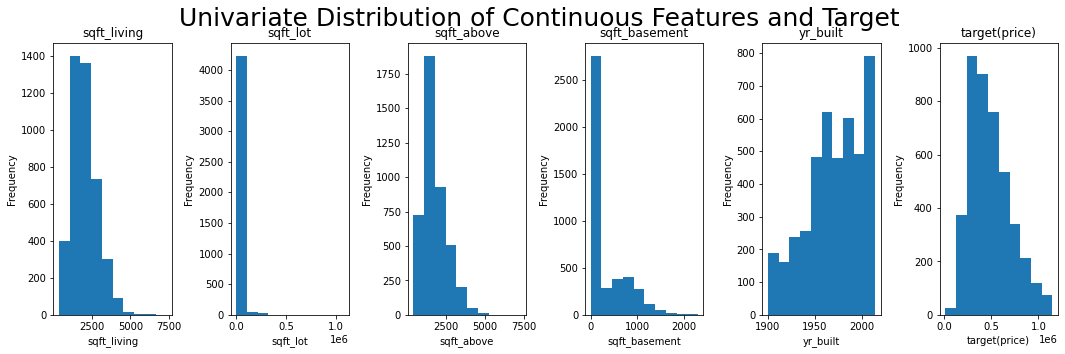

In [18]:
width = 6
fig, ax = plt.subplots(1, width, figsize = (18, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Univariate Distribution of Continuous Features and Target', fontsize = 25)
for i in range(len(ax)):
    ax[i].hist(df[to_plot[i]])
    if to_plot[i] != 'price':
        ax[i].title.set_text(to_plot[i])
        ax[i].set_xlabel(to_plot[i])
        ax[i].set_ylabel('Frequency')
    else:
        ax[i].title.set_text('target(price)')
        ax[i].set_xlabel('target(price)')
        ax[i].set_ylabel('Frequency')

### Visualize the univariate distribution of each categorical features

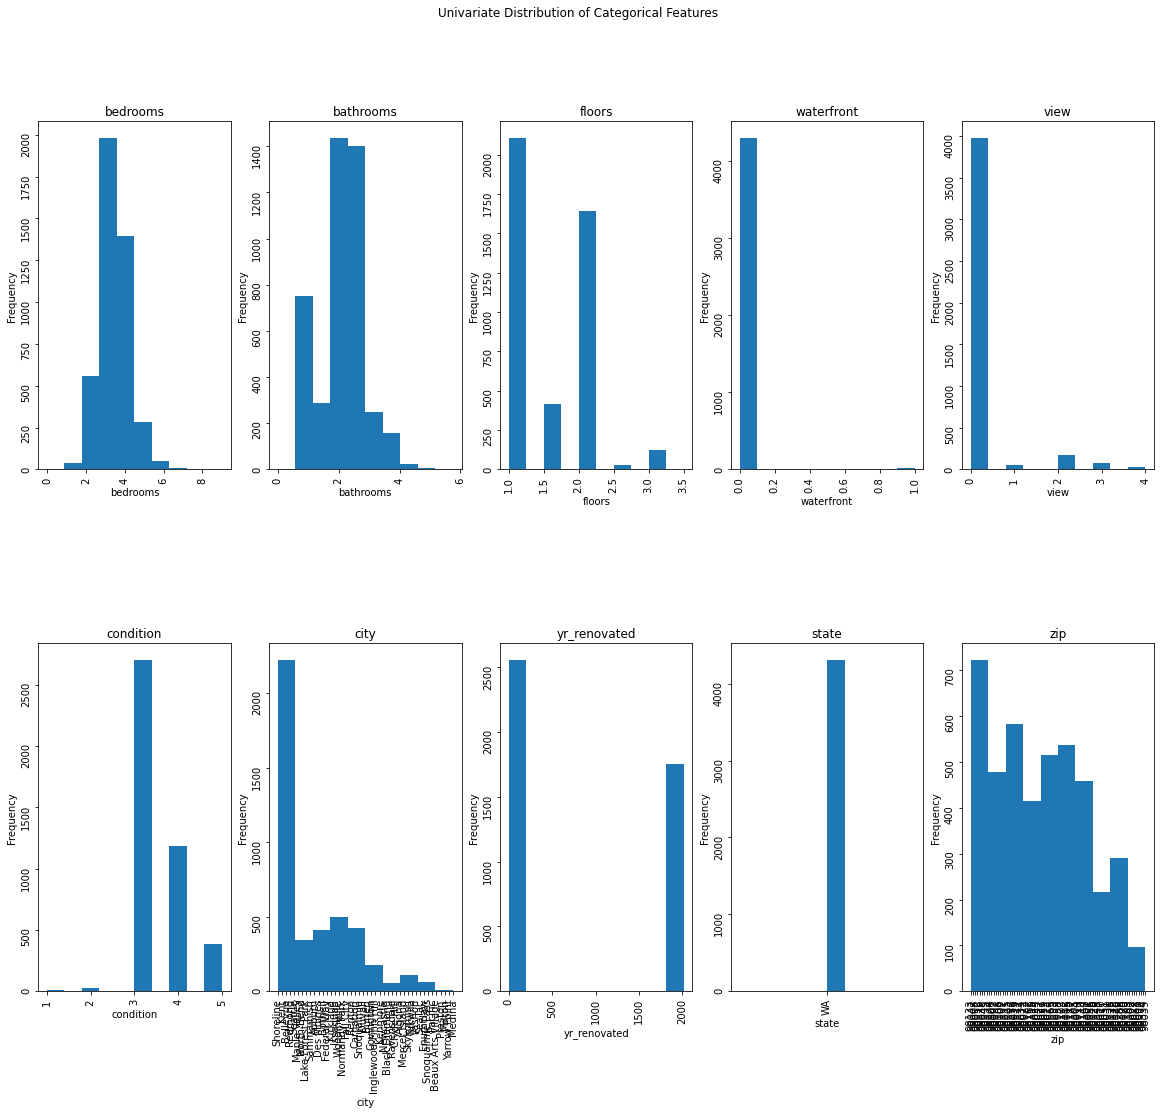

In [19]:
width = 5
fig, ax=plt.subplots(2, width, figsize=(20,16))
fig.suptitle('Univariate Distribution of Categorical Features')
fig.subplots_adjust(hspace=0.5)
for row in range(len(ax)):
    for column in range(len(ax[0])):
        i = width*row +column
        ax[row,column].hist(df_features[to_plot2[i]])
        ax[row,column].title.set_text(to_plot2[i])
        ax[row,column].set_xlabel(to_plot2[i])
        ax[row,column].set_ylabel('Frequency')
        ax[row,column].tick_params(labelrotation=90)

        
plt.show()

#### It appears that the distribution of most of the continuous features and the target are highly skewed. As a result, scaling maybe helpful.
#### It also appears that all listings are from the state of Washington. As a result, we can drop that column.

In [20]:
df_features = df_features.drop(columns=['state'])
categorical_var.remove('state')

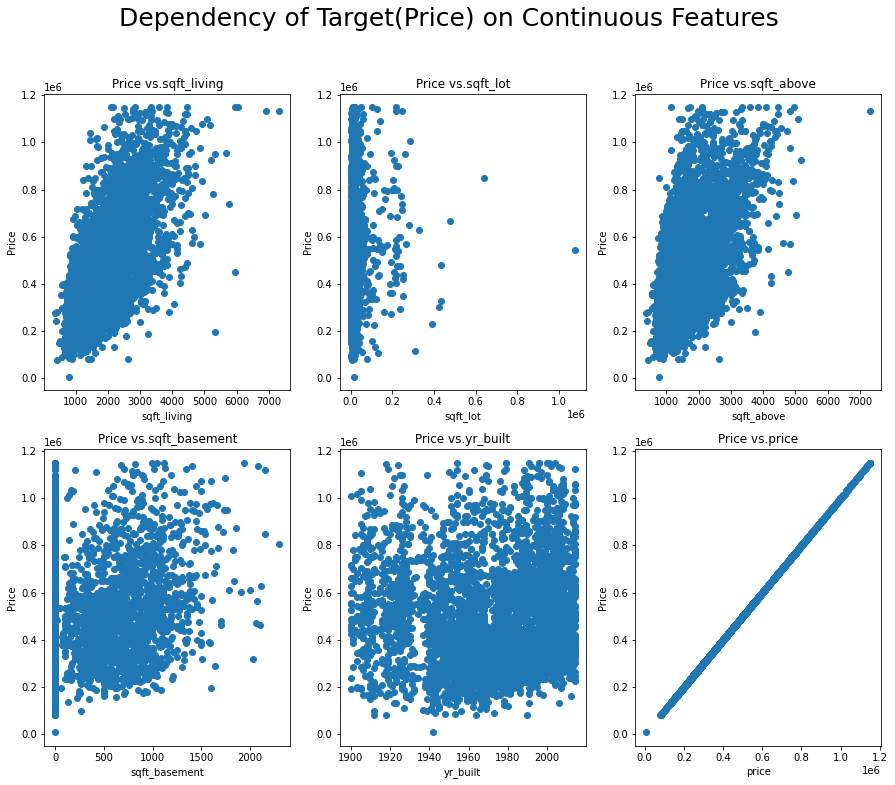

In [21]:
width = 3
fig, ax = plt.subplots(2,width, figsize = (15, 12))
fig.suptitle('Dependency of Target(Price) on Continuous Features', fontsize = 25)
for row in range(len(ax)):
    for column in range(len(ax[0])):
        i = width*row + column
        ax[row,column].scatter(df[continuous_var[i]], df['price'])
        ax[row,column].title.set_text('Price vs.' + to_plot[i])
        ax[row,column].set_xlabel(to_plot[i])
        ax[row,column].set_ylabel('Price')

#### It appears that Sqft_living & Sqft_above is most positively correlated with price.

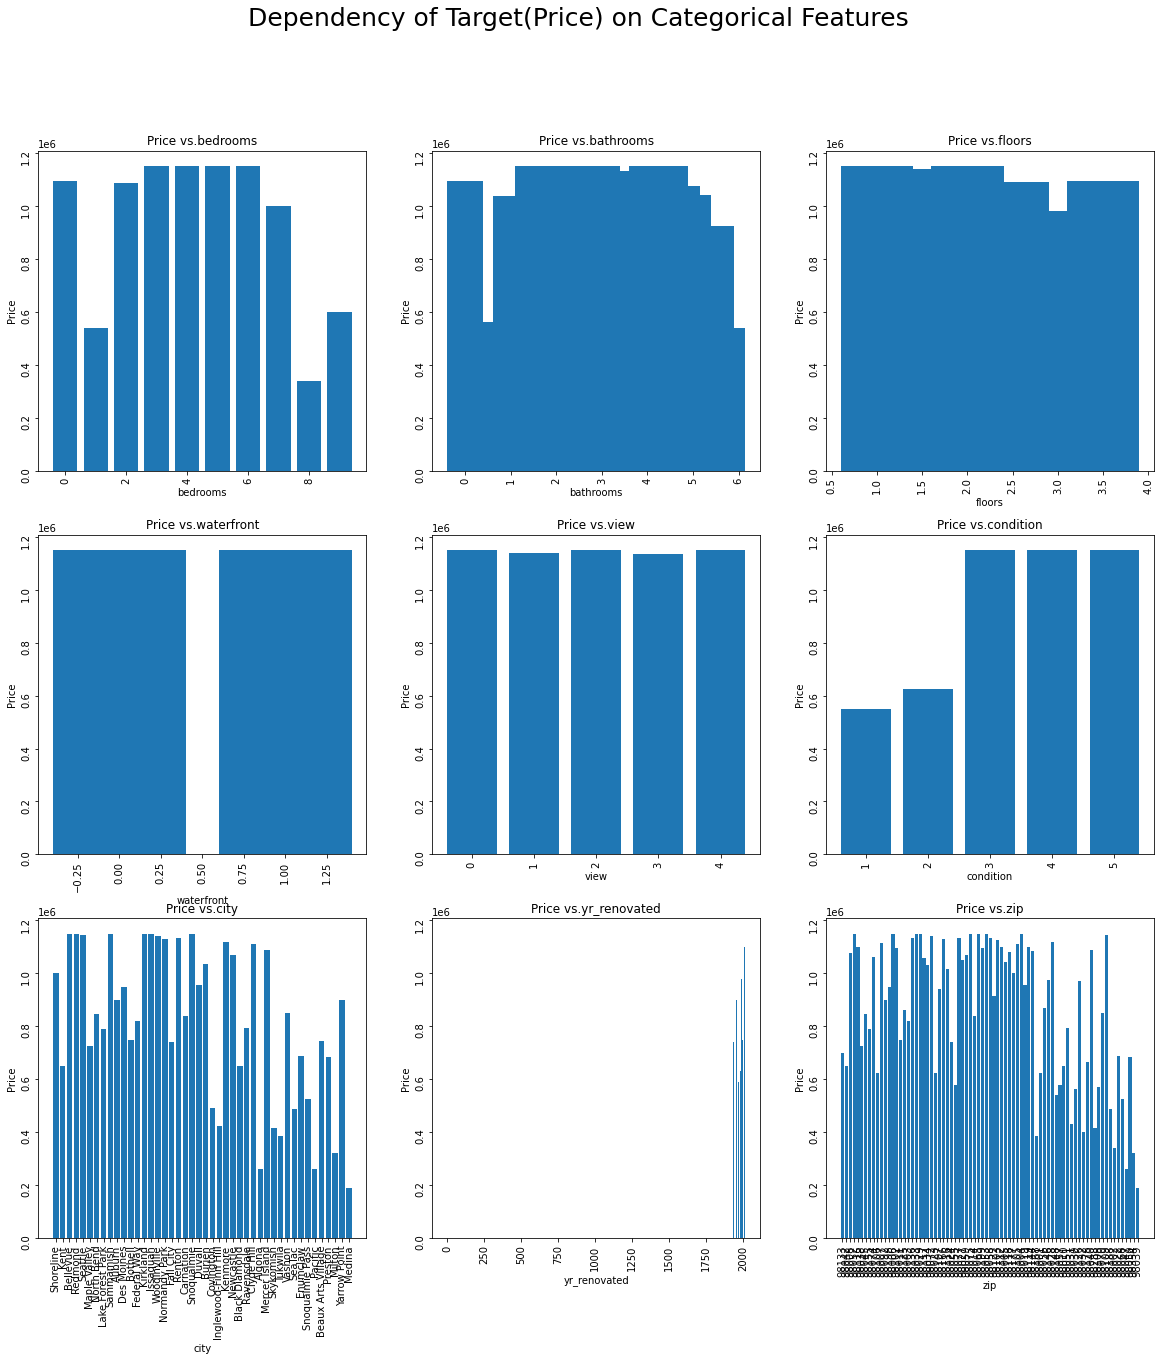

In [40]:
width = 3
fig, ax = plt.subplots(3,width, figsize = (20, 20))
fig.suptitle('Dependency of Target(Price) on Categorical Features', fontsize = 25)
for row in range(len(ax)):
    for column in range(len(ax[0])):
        i = width*row + column
        ax[row,column].bar(df_features[categorical_var[i]], df['price'])
        ax[row,column].title.set_text('Price vs.' + categorical_var[i])
        ax[row,column].set_xlabel(categorical_var[i])
        ax[row,column].set_ylabel('Price')
        ax[row,column].tick_params(labelrotation=90)

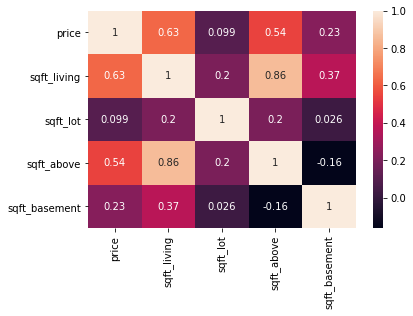

In [23]:
sns.heatmap(df[["price", "sqft_living", "sqft_lot", "sqft_above", "sqft_basement"]].corr(), annot=True);

## Step 2
### Split data into test set and training set.
### Compare models and preprocessing methods

### Split data in training and test set.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df_features, df['price'], random_state=42)

### Unscaled Baseline

In [26]:
# Unscaled
categories = X_train.dtypes == 'object'
preprocess = make_column_transformer(
    (SimpleImputer(strategy='mean'), ~categories),
    (OneHotEncoder(handle_unknown = 'ignore'), categories))

In [27]:
lr_pip = make_pipeline(preprocess, LinearRegression())
scores = np.mean(cross_val_score(lr_pip,X_train,y_train, scoring = "r2"))
print(f'mean cv accuracy using linear regression: {scores:0.8f}')


mean cv accuracy using linear regression: 0.76194945


#### Before removing outliers, our mean cv accuracy was ~0.5

#### Adding in Target Encoder

In [28]:
# Linear Regression
lr_pip = make_pipeline(TargetEncoder(cols = 'zip'), preprocess, LinearRegression())
scores = np.mean(cross_val_score(lr_pip,X_train,y_train))
print(f'mean cv accuracy using lr: {scores:0.8f}')


mean cv accuracy using lr: 0.76203020


### Adding in Standard Scaling for Continuous Variables

In [29]:
# With StandardScaler()
categories = X_train.dtypes == 'object'
preprocess = make_column_transformer(
    (SimpleImputer(strategy='mean'), ~categories),
    (StandardScaler(), ~categories),
    (OneHotEncoder(handle_unknown = 'ignore'), categories))

In [30]:
# Linear Regression
lr_pip = make_pipeline(TargetEncoder(cols = 'zip'), preprocess, LinearRegression())
scores = np.mean(cross_val_score(lr_pip,X_train,y_train))
print(f'mean cv accuracy using lr: {scores:0.8f}')


mean cv accuracy using lr: 0.76198341


#### Does scaling the data with StandardScaler help?
#### Whereas we proposed that scaling the data would help, we can see that scaling the data did not influence the cross-validation accuracy much. It may have improved very slightly, but that is trivial given the randomness in our sampling.

### Other Regression Models
#### We will be using both Decision Tree Regressor and Random Forest Regressor. We will first be comparing the average cross validation r2 scores of the two regressors and then choose one to conduct parameter tuning on.

#### Upon doing some research on both regressors, we found that Random Forest Regressor requires minimum preprocessing, as it is very robust to outliers. For Decision Tree Regressor, it is recommended that removal of outliers is completed in the preprocessing steps, which we have done in the data processing step.

In [31]:
dec_tree_pip = Pipeline([('targerencoder', TargetEncoder(cols = 'zip')),
                         ('preprocess', preprocess),
                       ('regressor',DecisionTreeRegressor())])

In [32]:
score_tree = np.mean(cross_val_score(dec_tree_pip,X_train,y_train, scoring='r2'))
print(f'mean cv accuracy using decision tree regressor: {score_tree:0.8f}')


mean cv accuracy using decision tree regressor: 0.49517677


In [33]:
for_pip = make_pipeline(TargetEncoder(cols = 'zip'), 
                        preprocess, 
                       RandomForestRegressor())
score_for = np.mean(cross_val_score(for_pip,X_train,y_train, scoring='r2'))

In [34]:
print(f'mean cv accuracy using random forest regressor: {score_for:0.8f}')


mean cv accuracy using random forest regressor: 0.71605883


## Step 3
### Parameter tuning for best performing model

### Parameter Tuning for Random Forest Regressor

In [35]:
param_grid = dict(randomforestregressor__max_depth = [int(x) for x in np.linspace(2, 80, num = 10)],
                  randomforestregressor__min_samples_leaf = [1, 2, 4],
                  randomforestregressor__n_estimators = [2,10,50,100],
                 )
grid = GridSearchCV(for_pip, param_grid, return_train_score = True)
grid.fit(X_train, y_train)
mean_score = np.mean(grid.score(X_train, y_train))

print(f'mean training gridsearch cv accuracy using decision tree: {mean_score:0.8f}')
print(grid.score(X_test, y_test))
print(grid.best_params_)

mean training gridsearch cv accuracy using decision tree: 0.96227053
0.7096619611558104
{'randomforestregressor__max_depth': 71, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 100}


#### Accuracy using decision tree on training data: 0.962 
#### Accuracy using decision tree on testing data: 0.709

## Step 4
### Choose most important features

In [41]:
params = {'max_depth' : 54, 'min_samples_leaf' : 1, 'n_estimators' : 100}
model_rfr = RandomForestRegressor(**params)
pipe_rfr =Pipeline([("Preprocessor", preprocess),
                   ("scaler", model_rfr)]).fit(X_train, y_train)
feature_importance = sorted(pipe_rfr["scaler"].feature_importances_)
sorted_idx = feature_importance[-5:]

categorical = X_train.dtypes == 'object'
col_con = X_train[X_train.columns[~categorical]].columns

col_cat = pipe_rfr.named_steps['Preprocessor'].transformers_[2][1].get_feature_names()

all_column_names = np.array(list(col_con) + list(col_cat))
print('Top 5 Features in Determining Housing Price')
names = []
importances = []

for name, importance in zip(all_column_names, sorted_idx):
    print(name, importance)
    names.append(name)
    importances.append(importance)

Top 5 Features in Determining Housing Price
sqft_living 0.025464594660203784
sqft_lot 0.0283763143750545
sqft_above 0.04935400480616222
sqft_basement 0.22174982707700241
yr_built 0.224342033051364
